Adınız: Mert

Soyadınız:Gökce

Okul Numaranız:2212721057

GitHub Repo Bağlantısı: https://github.com/mertgokce07/CNN_siniflandirma

model2.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset"

In [ ]:
import os
print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR + "/ayakkabi")[:3])
print(os.listdir(DATA_DIR + "/bot")[:3])

['ayakkabi', 'bot']
['IMG_1363.jpg', 'IMG_1367.jpg', 'IMG_1365.jpg']
['IMG_1562.jpg', 'IMG_1558.jpg', 'IMG_1559.jpg']


In [ ]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 16
SEED = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = full_ds.class_names
NUM_CLASSES = len(class_names)
print("Sınıflar:", class_names)

Found 306 files belonging to 2 classes.
Sınıflar: ['ayakkabi', 'bot']


In [ ]:
ds_size = full_ds.cardinality().numpy()

test_size = int(ds_size * 0.15)
val_size  = int(ds_size * 0.15)
train_size = ds_size - test_size - val_size

train_ds = full_ds.take(train_size)
temp_ds  = full_ds.skip(train_size)
val_ds   = temp_ds.take(val_size)
test_ds  = temp_ds.skip(val_size)

print("Train / Val / Test:", train_size, val_size, test_size)


Train / Val / Test: 14 3 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(200, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), #Modelin beklediği girdi şeklini tanımlar (Örneğin 128*128 piksel ve 3 renk kanalı).

    layers.Rescaling(1./255), #Görüntüdeki piksel değerlerini 0 ile 1 arasına ölçekler. Bu, derin öğrenme modellerinin daha iyi ve hızlı öğrenmesi için standart bir ön işleme adımıdır.

    layers.Conv2D(32, (3,3), activation="relu"), #32 adet temel özellik haritası çıkarır. 3x3 kernel
    layers.MaxPooling2D(), #Özellik haritasının boyutunu küçültür (downsampling), temel özellikleri korurken hesaplama maliyetini düşürür.

    layers.Conv2D(64, (3,3), activation="relu"), #Daha karmaşık 64 özellik haritası çıkarır.
    layers.MaxPooling2D(), #Boyutu tekrar küçültür.

    layers.Conv2D(128, (3,3), activation="relu"), #En karmaşık 128 özellik haritası çıkarır (genellikle yüksek seviyeli parçalar).
    layers.MaxPooling2D(), #Boyutu son kez küçültür.

    layers.Flatten(), # 3 boyutlu çıktıları (en son 128 özellik haritası) alıp, tamamen bağlı katmanlara giriş yapmak üzere tek boyutlu bir vektöre (düzleştirir) dönüştürür.
    layers.Dense(128, activation="relu"), #Tamamen bağlı katman (Hidden Layer). Vektördeki tüm özellikleri birleştirerek yüksek seviyeli ilişkiler kurar.
    layers.Dropout(0.3), #Aşırı uyumu (overfitting) azaltmak için rastgele nöronların %30'unu bir eğitim adımında kapatır.
    layers.Dense(NUM_CLASSES, activation="softmax") #Çıktı katmanı. Sınıf sayınız kadar çıktı verir ve olasılık dağılımını elde etmek için softmax aktivasyonunu kullanır.
])

model.summary() #bu katmanların her birinin çıktı şeklini ve içerdiği parametre sayısını (öğrenilebilir ağırlık ve sapma) detaylı olarak listeleyecektir

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.6552 - loss: 0.7928 - val_accuracy: 0.6250 - val_loss: 0.6549
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 27s 537ms/step - accuracy: 0.6786 - loss: 0.6280 - val_accuracy: 0.7083 - val_loss: 0.6655
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step - accuracy: 0.7071 - loss: 0.6457 - val_accuracy: 0.7500 - val_loss: 0.5897
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 612ms/step - accuracy: 0.7090 - loss: 0.5544 - val_accuracy: 0.7083 - val_loss: 0.5030
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - accuracy: 0.7987 - loss: 0.4373 - val_accuracy: 0.6458 - val_loss: 0.6675
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.8122 - loss: 0.4476 - val_accuracy: 0.8750 - val_loss: 0.3251
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 557ms/step - accuracy: 0.8811 - loss: 0.2882 - val_accuracy: 0.8958 - val_loss: 0.3131
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 495ms/step - accuracy: 0.9259 - loss: 0.1933 - val_accuracy: 0

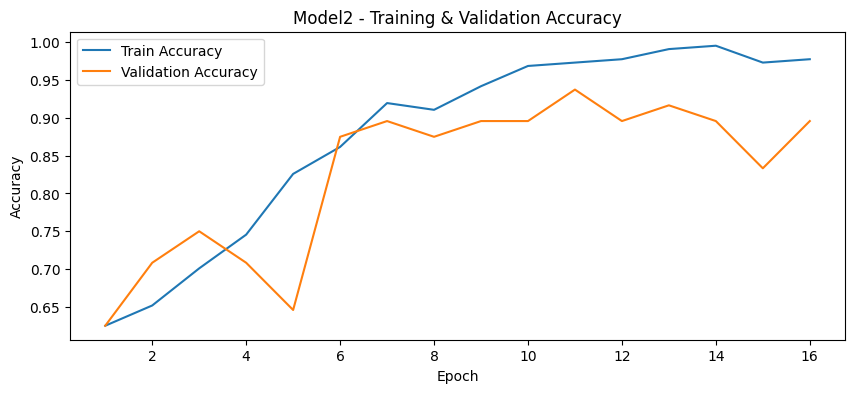

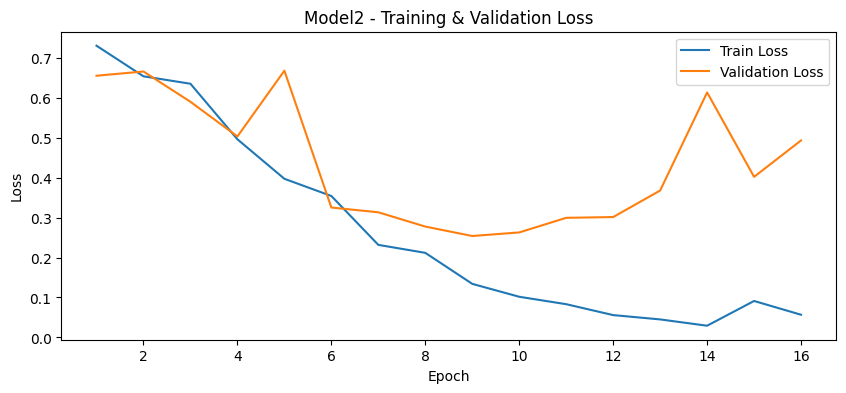

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(epochs, acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model2 - Training & Validation Accuracy")
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(epochs, loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Model2 - Training & Validation Loss")
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Model2 Test Loss:", test_loss)
print("Model2 Test Accuracy:", test_acc)

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 518ms/step - accuracy: 0.9012 - loss: 0.2687
Model2 Test Loss: 0.23536430299282074
Model2 Test Accuracy: 0.9117646813392639


### 📷 Tek Görsel ile Tahmin
Aşağıdan bir ayakkabı veya bot fotoğrafı yükleyerek modelin tahminini yüzde olarak görebilirsiniz.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMG_1460.jpg to IMG_1460.jpg


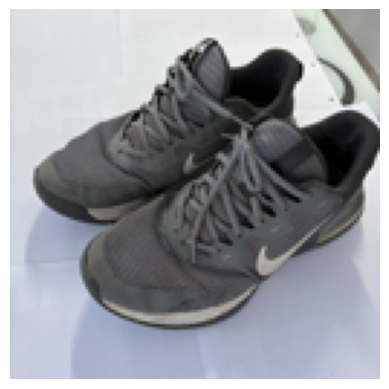

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
ayakkabi: %58.04
bot: %41.96

🟢 Tahmin: AYAKKABI (%58.04)


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Yüklenen dosya
img_path = list(uploaded.keys())[0]

# Görseli aç ve hazırla
img = Image.open(img_path).convert("RGB")
img = img.resize((128, 128))

plt.imshow(img)
plt.axis("off")
plt.show()

# Eğitimdekiyle birebir ön işleme
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Tahmin
pred = model.predict(img_array)[0]

class_names = ["ayakkabi", "bot"]

print(f"ayakkabi: %{pred[0]*100:.2f}")
print(f"bot: %{pred[1]*100:.2f}")

print(f"\n🟢 Tahmin: {class_names[np.argmax(pred)].upper()} (%{np.max(pred)*100:.2f})")